最近由于工作繁忙，博客更新较慢，所以请大家见谅！pymc是一个做贝叶斯分析的python库，我之前的博客中已经介绍了pymc的使用方法，今天再给大家做个更详细的应用案例介绍。该案例来自于github，我将其代码稍微修改,以便于阅读，最后我会将我博客的源代码以及相关参考资料的下载链接放在博客的结尾处，便于大家下载。

# 问题描述

我有一个某品牌的运动手环,我每天24小时戴着它,它记录了我每天睡眠和清醒的时间,一般人的睡眠时间都在晚上,清醒的时间都在白天。现在我想计算晚上某一个时间点我处于睡眠状态的概率,或者给定白天某一时间点,计算我处于清醒状态的概率:

                        P(sleeptime) or P(waketime)
                        
当然这个概率的计算是基于通过对现有的手环数据进行学习以后得到的,因此手环数据是我们观测到的实际数据,而我们要计算的P(sleeptime) 或者 P(waketime)则称之为后验概率。


# 数据

我的手环中存储了两个多月的关于我睡眠和清醒的数据，为了对数据建模,我将手环中的数据导出为csv文件， 这里我要说明的是我的手环数据可能并不一定是100%准确,手环判断睡眠和清醒状态可能是根据手环摆动的频率和次数或者我的心律的变化(都是我猜测的)，有时候如果在晚上我躺在床上静静的看书,手环可能会认定我已经入睡了。因此我们的数据并不是100%准确,数据中包含了部分错误数据(把清醒当成了睡眠或者把睡眠当成了清醒).不过这些都是真实数据,现实生活中真实数据往往不是完美的。

下面我们导入手环数据，手环数据分成两个文件,一个是睡眠状态的数据,另一个是清醒状态的数据。

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib

import json
s = json.load(open('../data/bmh_matplotlibrc.json'))
matplotlib.rcParams.update(s)
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

N_SAMPLES = 5000

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/root/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
sleep_data = pd.read_csv('../data/sleep_data.csv')
wake_data = pd.read_csv('../data/wake_data.csv')

sleep_labels = ['21:00', '21:30', '22:00', '22:30', '23:00', '23:30', '00:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']
print('睡眠数据共有 %d 条' % len(sleep_data))

睡眠数据共有 11340 条


下面我们将通过散点图来查看睡眠数据的分布，通过散点图我们发现大部分入睡时间都集中在22:00以后，少部分入睡时间分布在21点至22点之间。这比较符合我的实际情况。需要说明的是这里我们只展示从清醒状态转换到睡眠状态的那个时间段即晚上21点到0点的数据分布,而0点以后睡眠的概率会非常高(接近1),所以没必要展示。

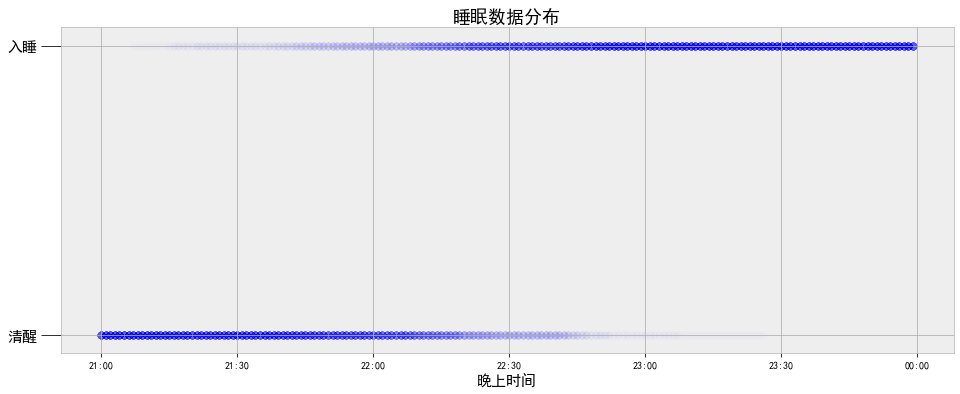

In [3]:
figsize(16, 6);

_=plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b');
plt.yticks([0, 1], ['清醒', '入睡'],fontsize=15); 
plt.xlabel('晚上时间',fontsize=15); 
plt.title('睡眠数据分布', size = 18);

plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

接下来我们通过散点图来查看清醒数据的分布，通过散点图我们发现大部分清醒时间都集中在6:00以后，少部分入睡时间分布在5点至6点之间。这也比较符合我的实际情况。这里我们只展示从睡眠状态转换到清醒状态的那个时间段即早上5点到8点的数据分布,而8点以后清醒的概率会非常高(接近1),所以没必要展示。

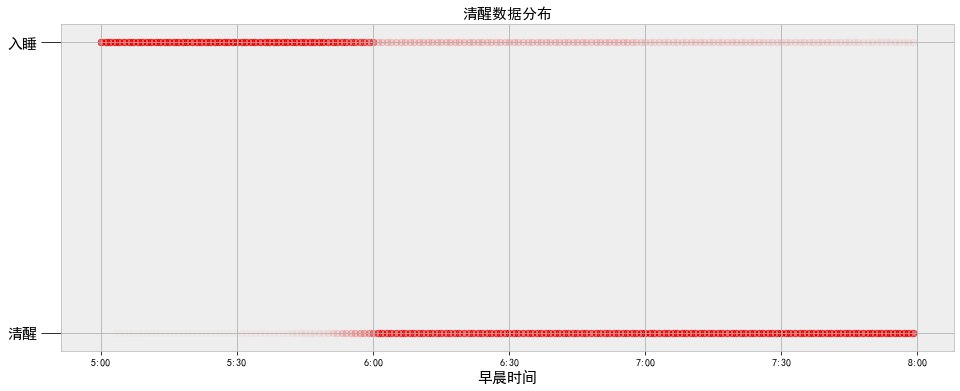

In [4]:
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['清醒', '入睡'],fontsize=15); 
plt.xlabel('早晨时间',fontsize=15);
plt.title('清醒数据分布',fontsize=15)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

注意到我们的睡眠数据和清醒数据都只包含两个状态(入睡状态和清醒状态)和一个维度(时间维度),那么对于只有两个状态和一个维度的数据进行建模,我们一般会使用逻辑函数：

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$

逻辑函数可以在数据的两个状态中进行平滑的过渡,我们所需要做的利用pycm来拟合出一条完美的逻辑函数曲线。说的具体一点就是我们要找到符合我们数据规律的两个逻辑函数的参数$\alpha$和$\beta$。在逻辑函数中$\alpha$和$\beta$作用是决定逻辑函数曲线的方向和位移,其中$\beta$决定曲线的方向，而$\alpha$决定曲线的位移。

下面我们看一下只有一个$\beta$参数的逻辑函数的形状：

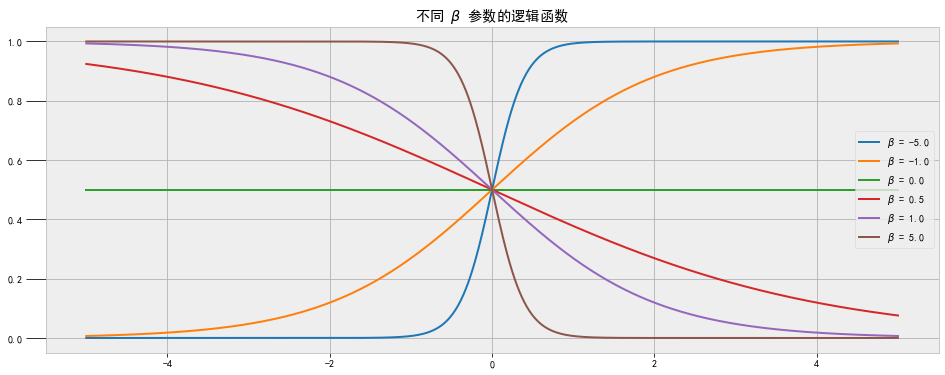

In [5]:
figsize(16, 6)

# 只有一个beta参数的逻辑函数
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

x = np.linspace(-5, 5, 1000)
for beta in [-5, -1,0, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'不同 $\beta$ 参数的逻辑函数');

由上图可知当$\beta$ < 0时逻辑函数是个“S”形曲线，而当$\beta$ >0时逻辑函数是个“反S”形曲线.而当$\beta$ = -1时的逻辑函数是我们非常熟悉的逻辑回归中常用的sigmod函数。

下面我们对逻辑函数的参数$\alpha$和$\beta$取不同的值来观察曲线的形状：

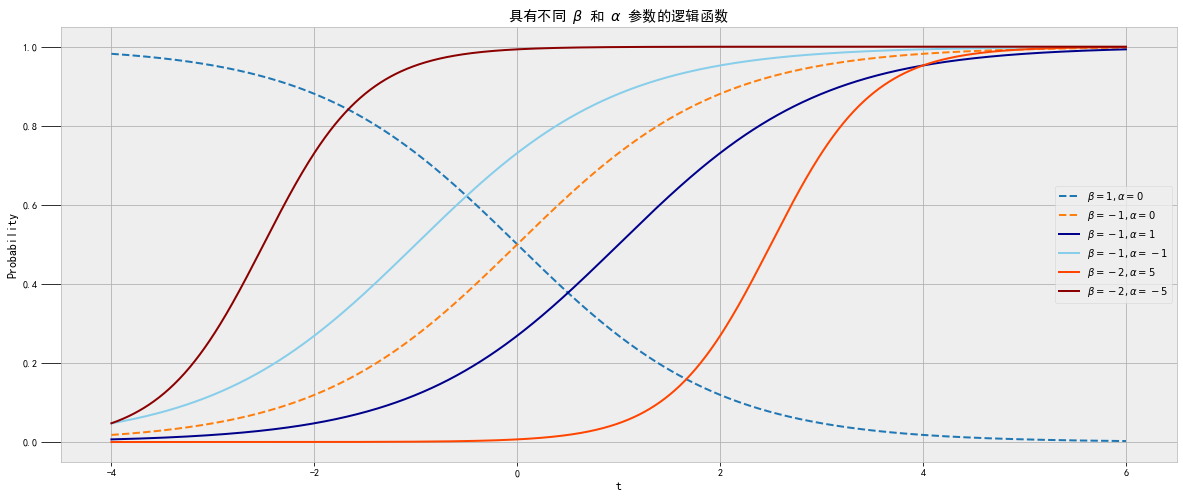

In [6]:
figsize(20, 8)

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 6, 1000)


plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1, \alpha = 0$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1, \alpha = 0$", ls="--", lw=2)

plt.plot(x, logistic(x, -1, 1), 
         label=r"$\beta = -1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, -1, -1),
         label=r"$\beta = -1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -2, 5), 
         label=r"$\beta = -2, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -2, -5), 
         label=r"$\beta = -2, \alpha = -5$", color="darkred")
plt.legend(); plt.ylabel('Probability'); plt.xlabel('t')
plt.title(r'具有不同 $\beta$ 和 $\alpha$ 参数的逻辑函数');

由上图可知当$\alpha$ > 0时逻辑函数曲线发生了右偏移，而当$\alpha$ < 0时逻辑函数曲线发生了左偏移。由此我们发现只要能找到合适的$\alpha$和$\beta$参数就能产生合适的逻辑函数来完美拟合我们的数据。

#  $\beta$ 和 $\alpha$的先验分布



由于我们事先并不知道参数$\alpha$和$\beta$的先验分布因此我们要使用贝叶斯的方法来寻找合适的$\alpha$和$\beta$，一般情况下我们会假定这两个参数会服从两个正太分布(先验概率分布),下面我们先复习一下正太分布,正太分布有两个重要的参数:$\mu$(均值)和$\sigma$(标准差)，不同的$\mu$和$\sigma$决定了不同形状的正太分布曲线，$\mu$可以是正数也可以是负数,而$\sigma$一般用正数来表示。不过这里我们会使用另外一个参数：$\tau$(精度)来替代$\sigma$，$\tau$是标准差的倒数,也就是说分布的标准差越小,精度就越高,反之亦然。下面是正太分布的概率密度函数的定义：

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

下面是三个不同$\mu$和$\tau$为参数的正太分布曲线,我们$\tau$越大，曲线越窄，分布的精度越高，$\tau$越小，曲线越宽，分布的精度越高低。

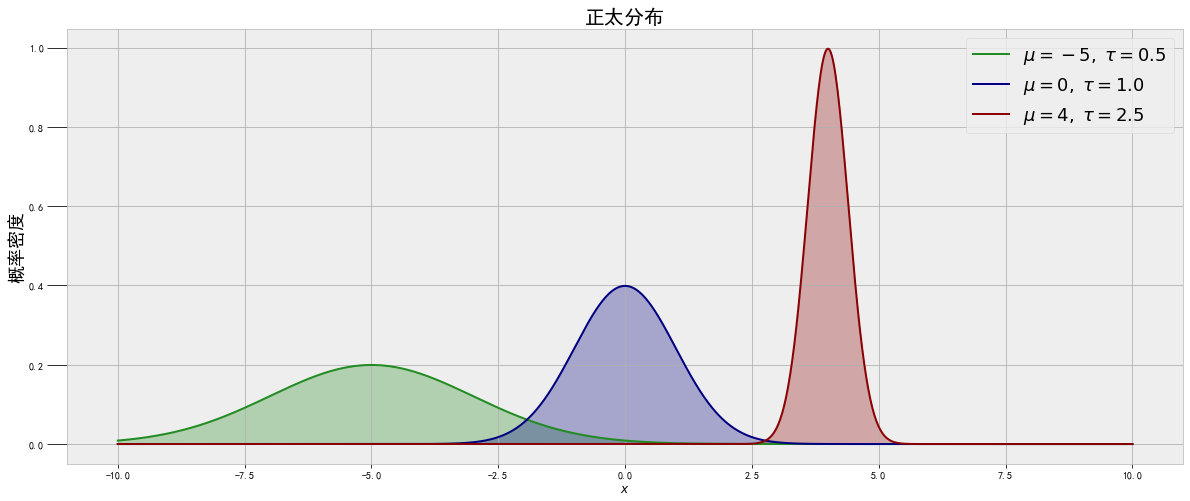

In [7]:
figsize(20, 8)

nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("forestgreen", "navy", "darkred")


params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1 / param[1])
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), 
             color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend(prop={'size':18});
plt.xlabel("$x$")
plt.ylabel("概率密度", size = 18)
plt.title("正太分布", size = 20);

# 马尔可夫链蒙特卡洛

马尔可夫链蒙特卡洛（Markov Chain Monte Carlo, MCMC）(https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/) 是指从概率分布中进行采样以构造最接近真实数据的概率分布的一种方法。这里因为我们无法直接计算逻辑函数的参数（$\alpha$和$\beta$），因此我们为这两个参数生成了数千个值（称为样本）以创建真实分布的近似值。MCMC背后的思想是，随着我们生成更多的样本，我们的近似值越来越接近实际的真实的数据分布。

蒙特卡洛（Monte Carlo）(http://statweb.stanford.edu/~owen/mc/) 是指使用大量的随机样本来拟合出实际分布参数的一种通用技术。可以将Monte Carlo视为进行了许多实验，每次更改模型中的变量并观察响应。通过选择随机值，我们可以探索参数空间的，即变量(参数)可能值的范围。在我们的问题中,逻辑函数的两个参数($\alpha$和$\beta$)服从正太先验概率，下面我们要探索一下使用正太先验变量的参数空间。

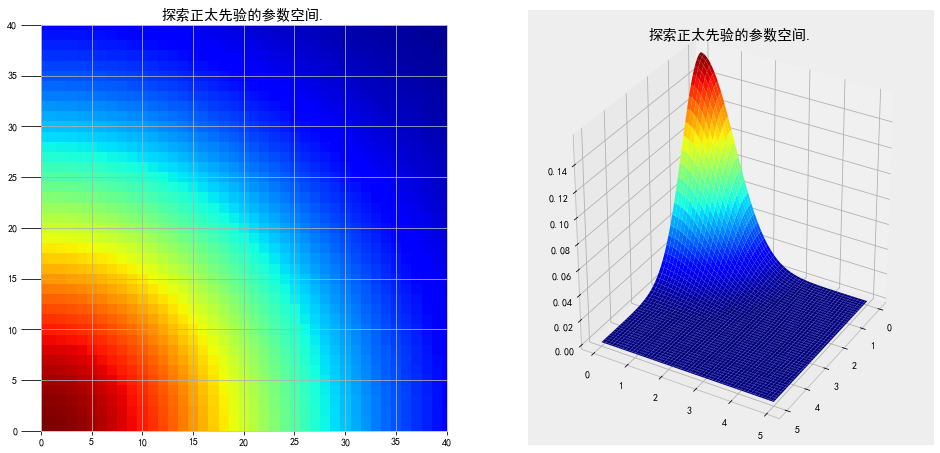

In [8]:
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet #色谱:蓝-青-黄-红
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1)
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',cmap=jet)
plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("探索正太先验的参数空间.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("探索正太先验的参数空间.");

正太分布的期望值是数据的均值：

$$ E[ X | \mu, \tau] = \mu$$ 

正太分布的标准差是:
$$ Var[ X | \mu, \tau) = \frac{1}{\tau}$$

因为我们不知道参数$\alpha$和$\beta$所服从的正太分布的参数$\mu$ 和 $\tau$的具体的数值，所以我们在初始化的时候设定 $\mu = 0$ 和一个相对较大的标准差比如$\tau=0.05$. 马尔可夫链蒙特卡洛（Markov Chain Monte Carlo）将对$\mu$ 和 $\tau$进行抽样,并最大化在真实数据下的$\mu$ 和 $\tau$似然度(likelihood)




# 特定时间下的睡眠的后验概率



逻辑函数描述了从清醒到入睡的转变，但是我们不了知道逻辑函数$\alpha$和$\beta$的准确值,我们的目的是找到使所观察到的数据的可能性(likelihood)最大化的逻辑函数的参数，一般情况下我们假设$\alpha$和$\beta$来自两个由$\mu$ 和 $\tau$定义的正太分布，MCMC算法分别为参数$\alpha$和$\beta$ 采样$\mu$和 $\tau$,以使$\mu$ 和 $\tau$最接近真实数据的分布。

数据通过伯努利(Bernoulli)变量和参数连接

## 伯努利(Bernoulli)变量

伯努利(Bernoulli)变量是离散型随机变量，它的值只有0或1。在我们的例子中我们可以对清醒或睡眠建模为一个伯努利变量，即清醒用1表示，入睡用用0表示。特定时间下入睡的伯努利(Bernoulli)变量有逻辑函数来定义：

$$ \text{Sleep Probability, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$


这里的$p(t_i)$为一个有独立时间变量的逻辑函数,所以上面的公式也可以这样写：

$$ P(\text{sleep} | t_i) = \text{Ber}(\frac{1}{1 + e^{(\beta t_i + \alpha)}})$$

MCMC的目标是使用现有的数据来找到𝛼和𝛽参数，并假定它们来自于正态先验。

### PyMC3 模型

我们正在使用Python中功能强大的贝叶斯推理库PyMC3, 该库能包含了Markov Chain Monte Carlo和其他推理算法。在github上有一本很好的PyMC的入门书籍[GitHub] (https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

以下代码创建模型并执行MCMC，为$\alpha$和$\beta$抽样N_SAMPLES个样本，指定的抽样算法是 Metropolic Hastings 
(http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf) ，我们将数据输入模型,并告诉模型数据是伯努利变量，模型于是会为数据找到最有可能的参数$\alpha$和$\beta$




In [9]:
# 对时间偏移量进行排序
sleep_data.sort_values('time_offset', inplace=True)

# 提取时间偏移量
time = np.array(sleep_data.loc[:, 'time_offset'])

# 观察值是indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [10]:
with pm.Model() as sleep_model:
    #创建alpha和beta的先验分布
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # 创建一个逻辑函数的确定性变量
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # 创建基于当前数据的伯努利变量
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # 使用 Metropolis Hastings 抽样
    step = pm.Metropolis()
    
    # 从后验中抽样
    sleep_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:38<00:00, 569.45draws/s]
The number of effective samples is smaller than 10% for some parameters.


跟踪变量trace包含了所有后验分布的样本,我们可以对这些样本进行可视化，以探索它们在采样过程中的变化。 随着样本的增加，MCMC算法收敛于最可能的值。

##  $\beta$ 和 $\alpha$ 后验分布的可视化

在trace中返回的值都是为参数的所有样本。 我们可以利用直方图对这些值进行可视化。

In [11]:
# 抽取alpha和beta的样本
alpha_samples = sleep_trace["alpha"][5000:, None]
beta_samples = sleep_trace["beta"][5000:, None]

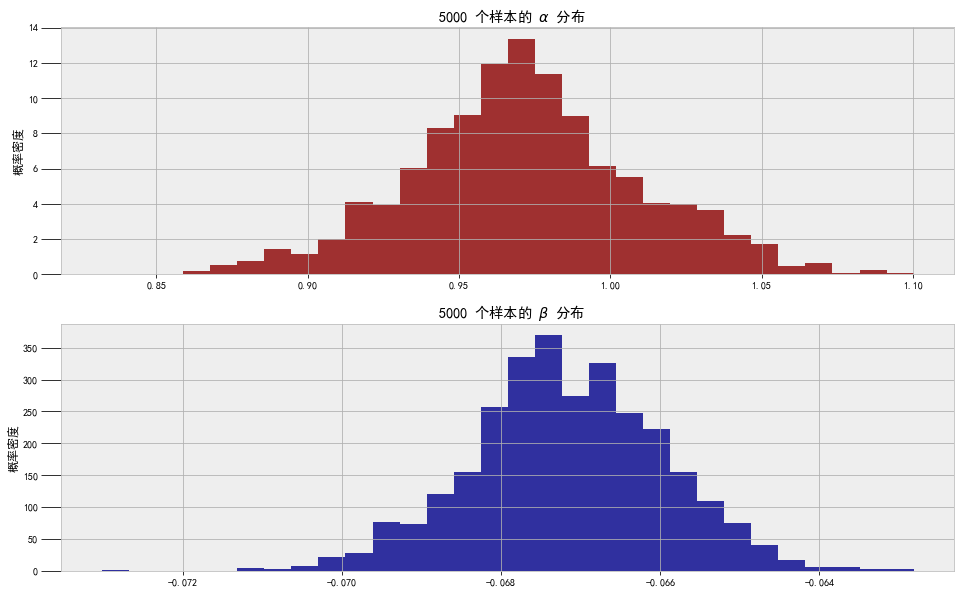

In [12]:
figsize(16, 10)

plt.subplot(211)
plt.title(r""" %d 个样本的 $\alpha$ 分布""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('概率密度')


plt.subplot(212)
plt.title(r""" %d 个样本的 $\beta$ 分布""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('概率密度');

从图中我们可以看到$\alpha$的均值集中在0.95至1的中间,而$\beta$的均值似乎比较接近0, 从前面画的逻辑函数的图形上来看,当$\beta$趋向于0时曲线趋于平坦,这说明清醒和睡眠的时间点存在重合的情况,这和实际情况相符,而$\alpha$不等于0说明逻辑函数向右发生了平移,这也就意味着模型找到了一个从清醒到睡眠的转折点,从睡眠数据的分布图上看这个时间点应该是在晚上10点左右。

# 后验参数的可视化

In [13]:
# 设定概率预测的时间长度
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e3)[:, None]

# 取参数的均值
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# 使用参数的均值所生成的概率
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

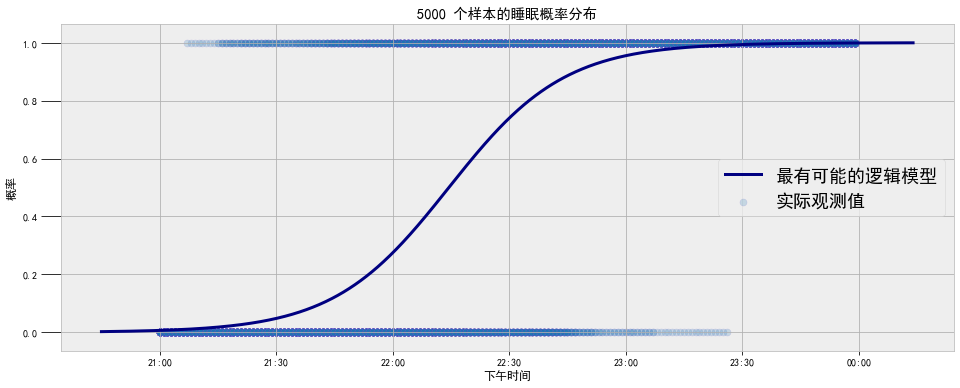

In [14]:
figsize(16, 6)

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="最有可能的逻辑模型")
plt.scatter(time, sleep_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='实际观测值')
plt.title('%d 个样本的睡眠概率分布' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('概率')
plt.xlabel('下午时间');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

从上图中可知,逻辑模型并不是十分完美,这是因为从清醒到入睡的时间出现大量重叠的情况,也就是在晚上10点到10点半之间存在大量的睡眠和清醒的重叠时间，这也将导致逻辑模型在这些数据重叠区域内不会有很好的预测效果。

In [15]:
print('睡眠概率大于 50% 的时间点位于下午 22:{} '.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

睡眠概率大于 50% 的时间点位于下午 22:14 


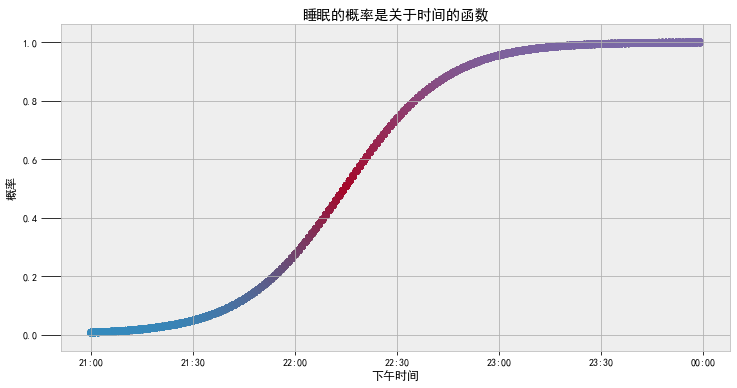

In [16]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('睡眠的概率是关于时间的函数')
plt.xlabel('下午时间');
plt.ylabel('概率');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

In [17]:
print('22点的睡眠概率为: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))
print('21:30的睡眠概率为: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))
print('22:30的睡眠概率为: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

22点的睡眠概率为: 27.45%.
21:30的睡眠概率为: 4.80%.
22:30的睡眠概率为: 73.96%.


# 置信区间

由于参数$\beta$ 和 $\alpha$本身存在很大的不确定性,因此我们需要画出$\beta$ 和 $\alpha$的95%的置信区间。

In [18]:
sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = stats.mstats.mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

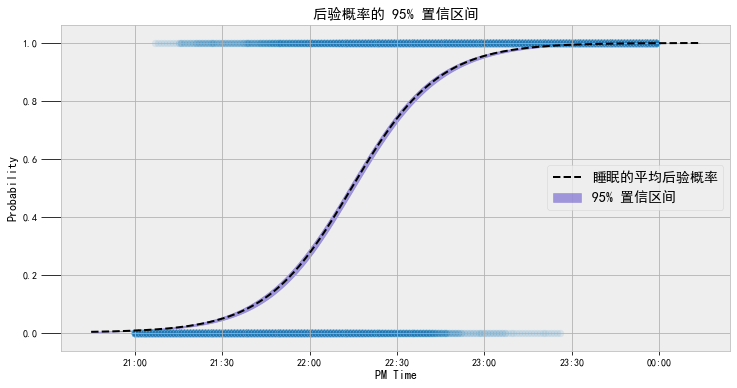

In [19]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% 置信区间')
plt.plot(time_est, sleep_est, lw=2, ls='--', 
         color='black', label="睡眠的平均后验概率")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability'); 
plt.title('后验概率的 95% 置信区间');

# 特定时间的后验概率分布

我们还可以基于参数的所有样本画出某个特定时间点的睡眠的后验概率的直方图。 

In [20]:
def sleep_posterior(time_offset, time):
    figsize(16, 8)
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('  %s点睡眠的概率分布' % time)
    plt.xlabel('睡眠概率'); plt.ylabel('样本量')
    plt.show();

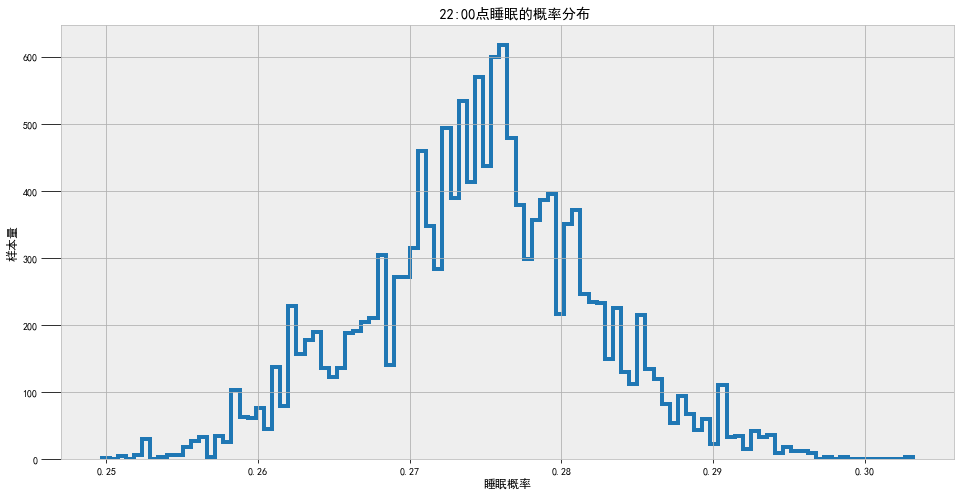

In [21]:
sleep_posterior(0, '22:00')

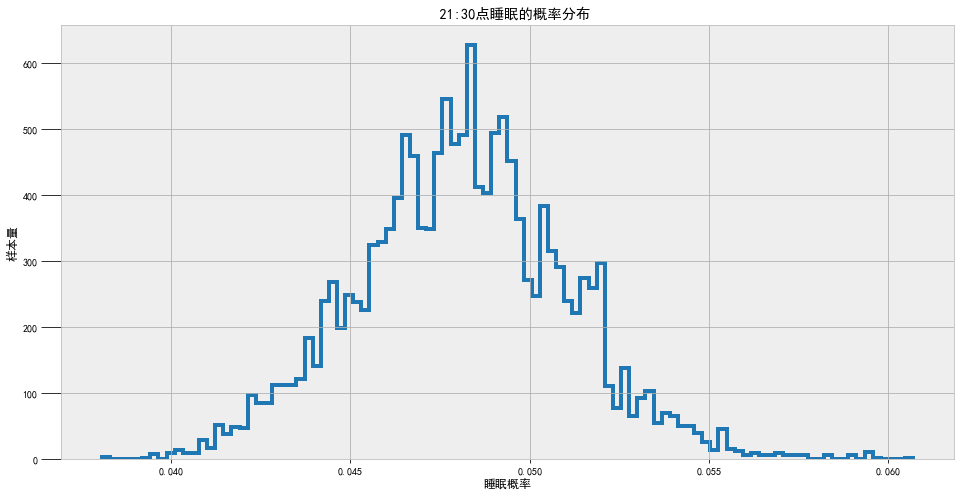

In [22]:
sleep_posterior(-30, '21:30')

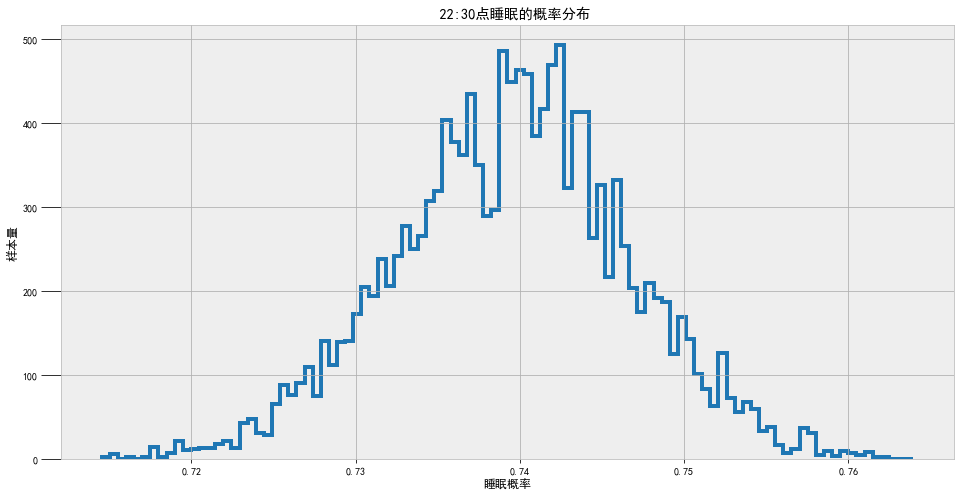

In [23]:
sleep_posterior(30, '22:30')

从以上的三个特定时间点的后验概率分布我们发现晚上22点的睡眠的后验概率的均值大概在0.27至0.28之间,这说明我(成年人)在晚上10点就入睡的可能性比较小,同时我们看到晚上21:30入睡的概率则更小,均值不到0.05,这也符合实际情况,大多数成年人一般不会在21:30就入睡了,不过22:30分的睡眠概率突然增加到了0.74,这也比较符合情况,因为大多数成年人一般都会在10点以后才入睡，从之前的分析我们可知当睡眠概率大于0.5的转折点是在22:14分。也就是说每当晚上过了22点14分，大部分成年人都会入睡,这应该比较符合常理。

In [24]:
print('alpha 参数估值: {:.6f}.'.format(alpha_est))
print('beta 参数估值: {:.6f}.'.format(beta_est))

alpha 参数估值: 0.971667.
beta 参数估值: -0.067180.


# 如何判断马尔可夫链蒙特卡罗模型是否收敛

我们如何知道模型是否收敛？ 我们可以查看轨迹(trace)或采样值的路径。 另一个选择是查看样本的自相关性(auto-correlation)。 在马尔可夫链建模中，样本与它们自身相关，因为下一个值取决于当前状态（或基于顺序的当前状态和过去状态）。 最初，该算法倾向于在搜索空间中徘徊，并且具有很高的自相关性。 随着算法的收敛，样本将在一个值附近稳定下来，并且测量是否收敛的一个标准是较低的自相关。 在这里，我们不会对收敛进行仔细的研究，但是我们可以画出所有样本的轨迹(trace)。

## 轨迹图
下面是 $\alpha$ 和 $\beta$所有样本采样的轨迹图

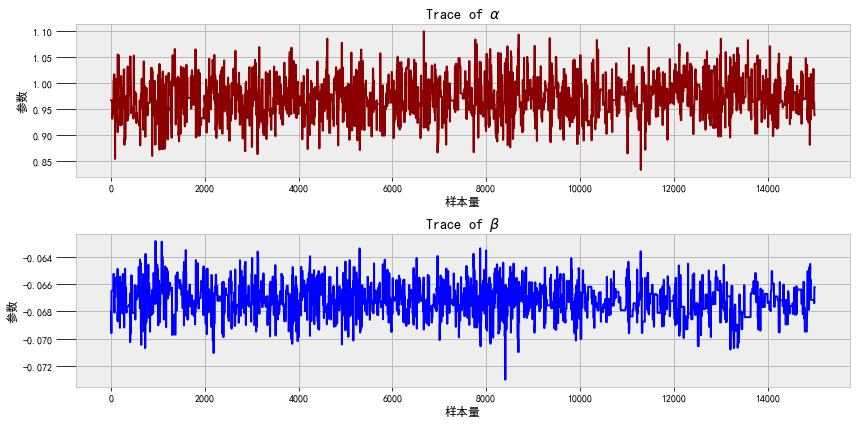

In [25]:
figsize(12, 6)
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('样本量'); plt.ylabel('参数');

plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('样本量'); plt.ylabel('参数');
plt.tight_layout(h_pad=0.8)

## 内置的诊断程序

PyMC3具有许多用于模型评估的内置诊断程序。 下面迹线图和自相关图。

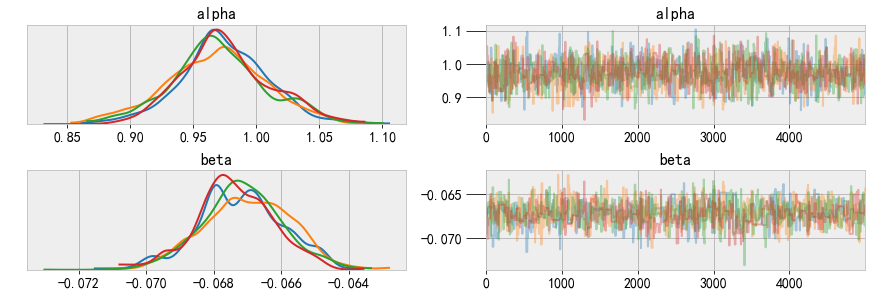

In [26]:
pm.traceplot(sleep_trace, ['alpha', 'beta']);

需要说明的是上图左边的上下两个图中各有四条曲线,这是因为我们的CUP是四核处理器,每个核独立采样,因此会有4条曲线。

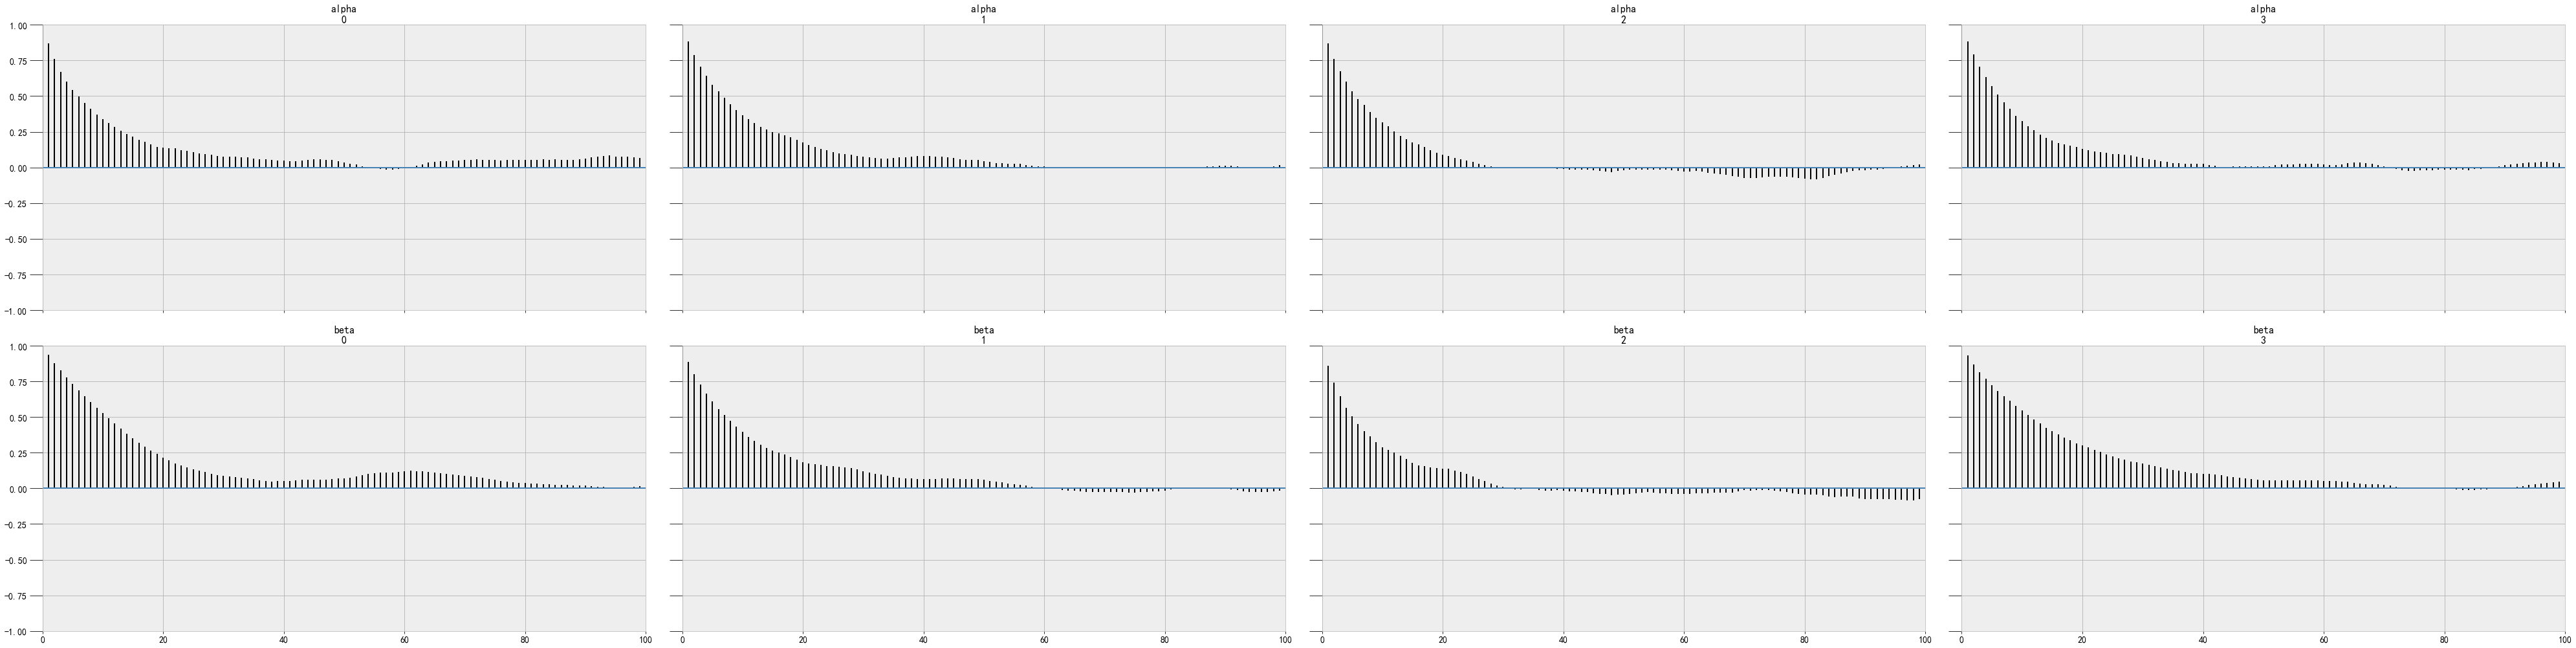

In [27]:
pm.autocorrplot(sleep_trace, ['alpha', 'beta']);

# 清醒数据建模

到目前为止我们已经完成了睡眠时间(21点至0点)pymc建模,同样我们也可以对清醒时候的数据(5点至8点)进行建模,下面我们对清醒数据进行建模,同样重复上述睡眠时间建模的步骤

In [28]:
wake_data.sort_values('time_offset', inplace=True)
time = np.array(wake_data.loc[:, 'time_offset'])
wake_obs = np.array(wake_data.loc[:, 'indicator'])

with pm.Model() as wake_model:
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    step = pm.Metropolis()
    wake_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:41<00:00, 532.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


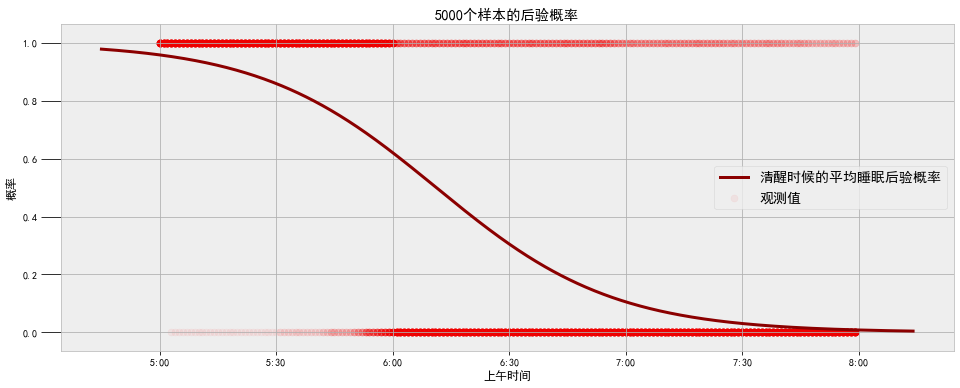

In [29]:
alpha_samples = wake_trace["alpha"][5000:, None]
beta_samples = wake_trace["beta"][5000:, None]
time_est = np.linspace(time.min()- 15, time.max() + 15, 1e3)[:, None]
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(16, 6)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="清醒时候的平均睡眠后验概率")
plt.scatter(time, wake_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='观测值')
plt.title('%d个样本的后验概率' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('概率')
plt.xlabel('上午时间');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);


In [30]:
print('清醒的概率大于50%的时间点位于上午 6:{}'.format(int(time_est[np.where(wake_est < 0.5)][0])))

清醒的概率大于50%的时间点位于上午 6:11


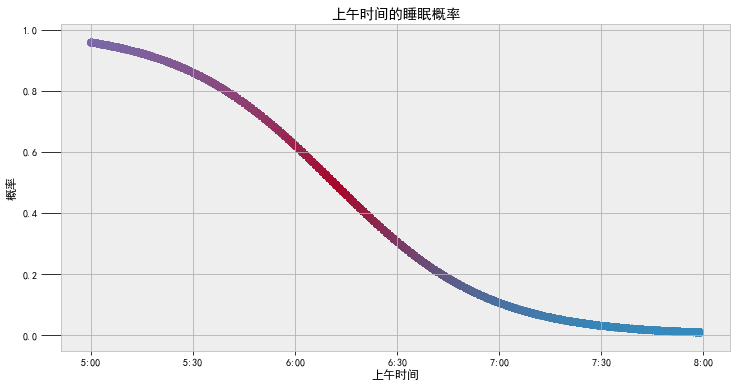

In [31]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = wake_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('上午时间的睡眠概率')
plt.xlabel('上午时间');
plt.ylabel('概率');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

In [32]:
print('上午5:30 清醒的概率: {:.2f}%.'.
      format(100 - (100 * logistic(-30, beta=beta_est, alpha=alpha_est))))
print('上午6:00清醒的概率: {:.2f}%.'.
      format(100 - (100 * logistic(0, beta=beta_est, alpha=alpha_est))))
print('上午6:30清醒的概率: {:.2f}%.'.
      format(100 - (100 * logistic(30, beta=beta_est, alpha=alpha_est))))

上午5:30 清醒的概率: 14.12%.
上午6:00清醒的概率: 37.96%.
上午6:30清醒的概率: 69.49%.


这里需要说明的是模型拟合出来的是上午时间的睡眠概率曲线,实际清醒概率等于1-睡眠概率,比如早上5:30的睡眠概率是0.8587,因此相对的清醒概率则是0.1413

# 睡眠时间长度模型

下面我们要对我的睡眠时间长度建模,首先我们从原始数据中读取我的每天数据时间长度，并查看睡眠时间的分布

In [33]:
raw_data = pd.read_csv('../data/sleep_wake.csv')
raw_data['length'] = 8 - (raw_data['Sleep'] / 60) + (raw_data['Wake'] / 60)
duration = raw_data['length']

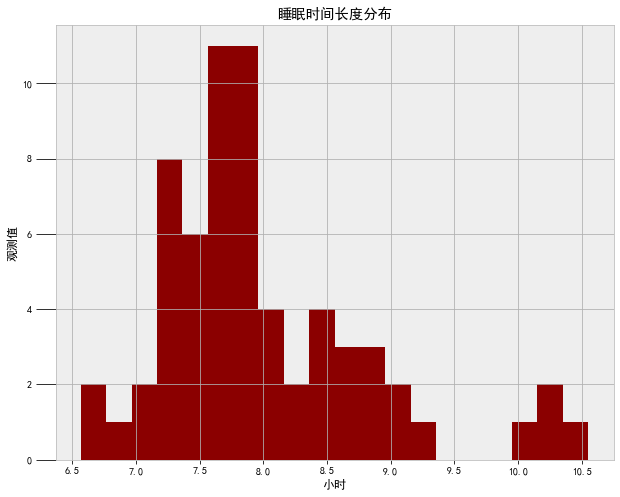

In [34]:
figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred')
plt.xlabel('小时'); plt.title('睡眠时间长度分布'); 
plt.ylabel('观测值');

由上面的睡眠时间长度分布可知分布呈现右偏,因此我们可以使用一个偏态分布(skewed distribution)对实际数据进行建模，不过我们还有一种选择,那就是使用一个双峰分布(bi-modal distribution)对实际数据建模,不过在这里我们还是选择前者(偏态分布)来对实际睡眠时间长度进行建模.

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


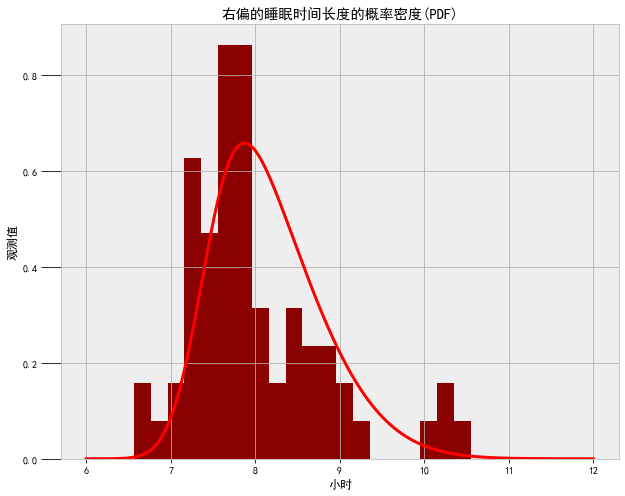

In [35]:
a = 3
fig, ax = plt.subplots(1, 1)
x = np.linspace(6, 12, 1e3)


figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred', normed=True);
plt.xlabel('小时'); plt.title('右偏的睡眠时间长度的概率密度(PDF)'); 
plt.ylabel('观测值');
plt.plot(x, stats.skewnorm.pdf(x, a, loc = 7.4, scale=1), 'r-', 
         lw=3, label='skewnorm pdf');

In [36]:
with pm.Model() as duration_model:
    # 定义三个参数的先验概率分布其中我们增加了一个偏度参数alpha_skew
    alpha_skew = pm.Normal('alpha_skew', mu=0, tau=0.5, testval=3.0)
    mu_ = pm.Normal('mu', mu=0, tau=0.5, testval=7.4)
    tau_ = pm.Normal('tau', mu=0, tau=0.5, testval=1.0)
    
    # Duration 为一个确定性变量
    duration_ = pm.SkewNormal('duration', alpha = alpha_skew, mu = mu_, 
                              sd = 1/tau_, observed = duration)
    
    # Metropolis Hastings 抽样
    step = pm.Metropolis()
    duration_trace = pm.sample(N_SAMPLES, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu]
>Metropolis: [alpha_skew]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:07<00:00, 2753.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [37]:
# 抽取最有可能的估值参数
alpha_skew_samples = duration_trace['alpha_skew'][5000:]
mu_samples = duration_trace['mu'][5000:]
tau_samples = duration_trace['tau'][5000:]

alpha_skew_est = alpha_skew_samples.mean()
mu_est = mu_samples.mean()
tau_est = tau_samples.mean()

# 睡眠长度后验分布的可视化

最可能的睡眠时间长度为 7.66 小时.


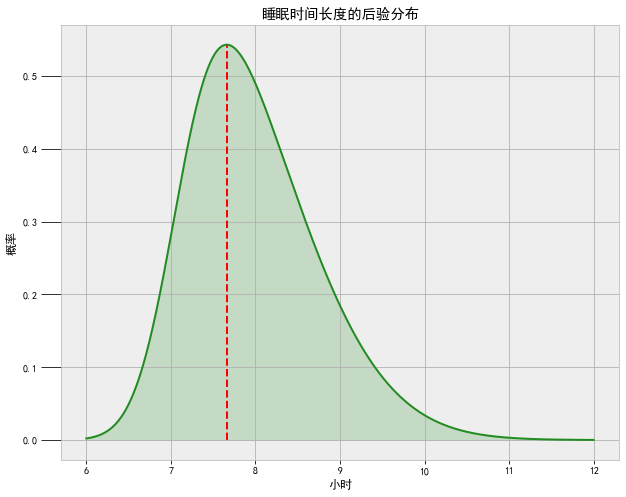

In [38]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
plt.plot(x, y, color = 'forestgreen')
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);
plt.xlabel('小时'); plt.ylabel('概率'); 
plt.title('睡眠时间长度的后验分布');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='red', 
           label = '最可能的睡眠时间长度');

print('最可能的睡眠时间长度为 {:.2f} 小时.'.format(x[np.argmax(y)]))

# 查询后验概率模型

In [39]:
print('睡眠时间至少6.5小时的概率为:{:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(6.5, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('睡眠时间至少8小时的概率为:{:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(8.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('睡眠时间至少9小时的概率为:{:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(9.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))

睡眠时间至少6.5小时的概率为:99.13%.
睡眠时间至少8小时的概率为:44.24%.
睡眠时间至少9小时的概率为:10.91%.


# 可视化后验和数据

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


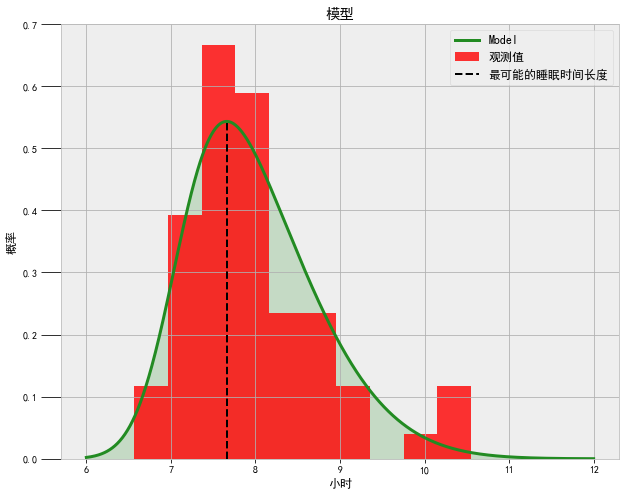

In [40]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
figsize(10, 8)
# 绘制后验概率分布
plt.plot(x, y, color = 'forestgreen', 
         label = 'Model', lw = 3)
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);

# 绘制观测值直方图
plt.hist(duration, bins=10, color = 'red', alpha=0.8,
         label='观测值', normed=True)
plt.xlabel('小时'); plt.ylabel('概率'); 
plt.title('模型');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='k', 
           label = '最可能的睡眠时间长度');
plt.legend(prop={'size':12});


这个偏态的后验分布模型看上去完美的拟合了我们的实际数据,美中不足的是右下角的一个小的波峰似乎没有被拟合到,我们似乎可以考虑使用两个单独的分布来对原始数据来进行拟合,或者使用一个双峰模型来进行拟合,不过总体而言，该模型仍然可以为我的睡眠时间概率提供合理的预测。

# 总结

根据实际观测数据，我们得到了以下结论：
* 平均而言，我到晚上10:14入睡 
* 平均而言，我早上6:11醒来
* 我的平均睡眠时间为7.67小时  

这些模型已经为我提供了有关睡眠方式的知识，更多的数据只会提高适用性。 我可以结合其他信息，例如星期几或日常活动，以查看它们如何影响我的睡眠，然后根据需要进行调整。 尽管这里有几个假设，但并未深入研究模型，不过这是使用贝叶斯方法分析实际数据的一个很好的开始。由于这是具有实际应用程序的项目，是学习的最佳方法，我期待将贝叶斯方法应用于其他问题！

# 参考资料

使用Python、PyMC3、ArviZ的贝叶斯统计实战开发(https://blog.csdn.net/weixin_42608414/article/details/99103110)  
Markov Chain Monte Carlo Without all the Bullshit(https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/)   
Bayesian Methods for Hackers(https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)    
Monte Carlo theory, methods and examples(http://statweb.stanford.edu/~owen/mc/)   
Bayesian Inference: Metropolis-Hastings Sampling(http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf)
